# Lab assignment: predicting car prices

<img src="img/carDepreciation.jpg" style="width:700px;height:300px;">

In this assignment we will attempt to predict how car prices vary (usually going down) from first hand to second hand, according to different vehicle characteristics. We will exploit ensemble techniques to try to obtain as good models as possible. 

## Guidelines

Throughout this notebook you will find empty cells that you will need to fill with your own code. Follow the instructions in the notebook and pay special attention to the following symbols.

<table>
 <tr><td width="80"><img src="img/question.png" style="width:auto;height:auto"></td><td style="text-align:left">You will need to solve a question by writing your own code or answer in the cell immediately below, or in a different file as instructed. Both correctness of the solution and code quality will be taken into account for marking.</td></tr>
 <tr><td width="80"><img src="img/exclamation.png" style="width:auto;height:auto"></td><td style="text-align:left">This is a hint or useful observation that can help you solve this assignment. You are not expected to write any solution, but you should pay attention to them to understand the assignment.</td></tr>
 <tr><td width="80"><img src="img/pro.png" style="width:auto;height:auto"></td><td style="text-align:left">This is an advanced and voluntary excercise that can help you gain a deeper knowledge into the topic. This exercise won't be taken into account towards marking, but you are encouraged to undertake it. Good luck!</td></tr>
</table>

The following code imports the core libraries and objects used. Feel free to import other stuff if you need to in subsequent cells:

In [5]:
import numpy as np
import pandas as pd
RANDOM_STATE = 42; np.random.seed(RANDOM_STATE)
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error

Lastly, if you need any help on the usage of a Python function you can place the writing cursor over its name and press Caps+Shift to produce a pop-out with related documentation. This will only work inside code cells. 

Let's go!

## Data loading and preprocessing

In this assignment we will work with the `vehicles` dataset, which was retrieved from <a href="https://en.wikipedia.org/wiki/Craigslist">Craigslist</a>:

In [6]:
df = pd.read_csv('./data/vehicles/vehicles.csv')
df

price    year manufacturer  condition    cylinders    fuel  odometer  \
0        6995  2000.0          gmc  excellent  8 cylinders     gas  167783.0   
1        8750  2013.0      hyundai  excellent  4 cylinders     gas   90821.0   
2       10900  2013.0       toyota       good  4 cylinders  hybrid   92800.0   
3       12500  2003.0   mitsubishi       good  4 cylinders     gas       NaN   
4       16995  2007.0          gmc       good  8 cylinders  diesel  254217.0   
...       ...     ...          ...        ...          ...     ...       ...   
423852   1600  2006.0      hyundai       fair  6 cylinders     gas  159980.0   
423853   9000  2003.0       toyota  excellent  8 cylinders     gas  160000.0   
423854    700  1994.0         ford       fair  6 cylinders     gas  212000.0   
423855   3800  1999.0      lincoln  excellent  8 cylinders     gas  160000.0   
423856   8650  2015.0       nissan        NaN          NaN     gas  160526.0   

       title_status transmission drive   type paint_color  
0             clean    automatic   4wd    NaN         red  
1             clean    automatic   fwd    NaN        grey  
2             clean    automatic   fwd    NaN        blue  
3             clean       manual   4wd  sedan        grey  
4             clean    automatic   4wd  truck       white  
...             ...          ...   ...    ...         ...  
423852        clean    automatic   fwd  sedan        blue  
423853        clean    automatic   4wd    SUV       green  
423854        clean       manual   rwd    NaN       green  
423855        clean    automatic   rwd  sedan         NaN  
423856        clean    automatic   fwd  sedan      silver  

[423857 rows x 12 columns]

Let's take a look at the columns and their meaning:
* `price`: the price (in dollars) the car is trying to be sold at.
* `year`: year when that car is being sold.
* `manufacturer`: the car brand (Audi, BMW...).
* `condition`: car status (like new, in good/bad condition...).
* `cylinders`: how many cylinders the engine has.
* `fuel`: what kind of fuel it uses.
* `odometer`: mileage it has when sold.
* `title_status`: if it's original or has been modified with extra pieces.
* `transmission`: type of transmission (manual, automatic...).
* `drive`: kind of drive (forward, rear...).
* `type`: category of car (compact, SUV, coupe...).
* `paint_color`: main color of the car (white, red...).

We've a faily large dataset (more than 400K rows), but there're quite a lot of missing values! The only column that is always there is `price`:

In [7]:
df.isna().sum(axis=0)

price                0
year             95114
manufacturer    110615
condition       247138
cylinders       226178
fuel             96643
odometer        153272
title_status     96098
transmission     95792
drive           192738
type            182700
paint_color     201654
dtype: int64

To simplify things, let's simply eliminate all rows that have missing information. This leaves us with barely 86K samples:

In [8]:
df = df.dropna(how='any')
df

price    year manufacturer  condition    cylinders    fuel  odometer  \
4       16995  2007.0          gmc       good  8 cylinders  diesel  254217.0   
5       13995  2012.0         ford       good  6 cylinders     gas  188406.0   
6        7995  2010.0    chevrolet       good  4 cylinders     gas  108124.0   
7        8995  2011.0    chevrolet       good  6 cylinders     gas  178054.0   
8       10995  2014.0         ford       good  6 cylinders     gas  170259.0   
...       ...     ...          ...        ...          ...     ...       ...   
423849   9885  2012.0       subaru  excellent  4 cylinders     gas   82000.0   
423850    750  2002.0       saturn    salvage  4 cylinders     gas   40000.0   
423851   4800  2002.0         ford       good  6 cylinders     gas   58000.0   
423852   1600  2006.0      hyundai       fair  6 cylinders     gas  159980.0   
423853   9000  2003.0       toyota  excellent  8 cylinders     gas  160000.0   

       title_status transmission drive       type paint_color  
4             clean    automatic   4wd      truck       white  
5             clean    automatic   4wd      truck        grey  
6             clean    automatic   4wd        SUV        grey  
7             clean    automatic   4wd        SUV       white  
8             clean    automatic   4wd        SUV       white  
...             ...          ...   ...        ...         ...  
423849        clean    automatic   4wd  hatchback      silver  
423850      missing       manual   fwd      coupe        blue  
423851        clean    automatic   rwd      coupe        blue  
423852        clean    automatic   fwd      sedan        blue  
423853        clean    automatic   4wd        SUV       green  

[85998 rows x 12 columns]

Now we should also change `year` and `odometer` to integer type. As for `cylinders`, it can have the value `'other'`, but we can remove the word `'cylinders'` itself:

In [5]:
df = df.astype({'price': 'int32', 'year': 'int16', 'odometer': 'int32'})
df['cylinders'].where(df['cylinders'] == 'other', df['cylinders'].str.replace('cylinders', ''))
df

price  year manufacturer  condition    cylinders    fuel  odometer  \
4       16995  2007          gmc       good  8 cylinders  diesel    254217   
5       13995  2012         ford       good  6 cylinders     gas    188406   
6        7995  2010    chevrolet       good  4 cylinders     gas    108124   
7        8995  2011    chevrolet       good  6 cylinders     gas    178054   
8       10995  2014         ford       good  6 cylinders     gas    170259   
...       ...   ...          ...        ...          ...     ...       ...   
423849   9885  2012       subaru  excellent  4 cylinders     gas     82000   
423850    750  2002       saturn    salvage  4 cylinders     gas     40000   
423851   4800  2002         ford       good  6 cylinders     gas     58000   
423852   1600  2006      hyundai       fair  6 cylinders     gas    159980   
423853   9000  2003       toyota  excellent  8 cylinders     gas    160000   

       title_status transmission drive       type paint_color  
4             clean    automatic   4wd      truck       white  
5             clean    automatic   4wd      truck        grey  
6             clean    automatic   4wd        SUV        grey  
7             clean    automatic   4wd        SUV       white  
8             clean    automatic   4wd        SUV       white  
...             ...          ...   ...        ...         ...  
423849        clean    automatic   4wd  hatchback      silver  
423850      missing       manual   fwd      coupe        blue  
423851        clean    automatic   rwd      coupe        blue  
423852        clean    automatic   fwd      sedan        blue  
423853        clean    automatic   4wd        SUV       green  

[85998 rows x 12 columns]

As for the numerical columns, note that there are some extreme values:
* `price`: it shouldn't be 0 (free cars?), but of course it shouldn't be either 2.49 billion $!
* `year`: there're really ancient cars (1923), and even a car from the future! (from 2021, perhaps a Delorean?)
* `odometer`: maybe it can be 0 for a brand-new car, but 10 million miles?

In [6]:
df.describe(percentiles=[0.01, 0.05, 0.10, 0.25, 0.50, 0.75, 0.90, 0.95, 0.99])

price          year      odometer
count  8.599800e+04  85998.000000  8.599800e+04
mean  -7.240961e+03   2009.090107  1.137648e+05
std    6.167590e+06      8.666905  1.241751e+05
min   -1.804436e+09   1923.000000  0.000000e+00
1%     0.000000e+00   1971.000000  1.100000e+02
5%     6.000000e+02   1996.000000  1.307700e+04
10%    2.495000e+03   2001.000000  2.800000e+04
25%    4.995000e+03   2006.000000  6.449175e+04
50%    8.995000e+03   2011.000000  1.079605e+05
75%    1.600000e+04   2015.000000  1.512170e+05
90%    2.687300e+04   2017.000000  1.916000e+05
95%    3.475000e+04   2018.000000  2.189906e+05
99%    4.950000e+04   2019.000000  2.890031e+05
max    1.234568e+08   2021.000000  1.000000e+07

So let's do the following:

<table>
 <tr><td width="80"><img src="img/question.png" style="width:auto;height:auto"></td><td style="text-align:left">

Filter out those car samples for which:
    <ul>
        <li>`price` is less than 500 or more than 50000 dollars.</li>
        <li>`year`  is less than 1990 or more than 2020.</li>
        <li>`odometer` is more than 300000 miles.</li>
    </ul>

 </td></tr>
</table>

In [7]:
####### INSERT YOUR CODE HERE
df = df [(df ["price"]>500) & (df ["price"] < 50000) & (df["year"]>1990) & (df["year"]<2020) & (df["odometer"]<300000)]
df


price  year manufacturer  condition    cylinders    fuel  odometer  \
4       16995  2007          gmc       good  8 cylinders  diesel    254217   
5       13995  2012         ford       good  6 cylinders     gas    188406   
6        7995  2010    chevrolet       good  4 cylinders     gas    108124   
7        8995  2011    chevrolet       good  6 cylinders     gas    178054   
8       10995  2014         ford       good  6 cylinders     gas    170259   
...       ...   ...          ...        ...          ...     ...       ...   
423849   9885  2012       subaru  excellent  4 cylinders     gas     82000   
423850    750  2002       saturn    salvage  4 cylinders     gas     40000   
423851   4800  2002         ford       good  6 cylinders     gas     58000   
423852   1600  2006      hyundai       fair  6 cylinders     gas    159980   
423853   9000  2003       toyota  excellent  8 cylinders     gas    160000   

       title_status transmission drive       type paint_color  
4             clean    automatic   4wd      truck       white  
5             clean    automatic   4wd      truck        grey  
6             clean    automatic   4wd        SUV        grey  
7             clean    automatic   4wd        SUV       white  
8             clean    automatic   4wd        SUV       white  
...             ...          ...   ...        ...         ...  
423849        clean    automatic   4wd  hatchback      silver  
423850      missing       manual   fwd      coupe        blue  
423851        clean    automatic   rwd      coupe        blue  
423852        clean    automatic   fwd      sedan        blue  
423853        clean    automatic   4wd        SUV       green  

[77220 rows x 12 columns]

Now we obtain reasonable distributions on price and year, except that there aren't many cars for very recent years (which makes sense, as those are mostly second hand cars, and in order to be second hand some years must pass!):

<table>
 <tr><td width="80"><img src="img/question.png" style="width:auto;height:auto"></td><td style="text-align:left">

Verify that the rest of features (all categorical) have reasonable values, and check which categories are allowed for each of those features.

 </td></tr>
</table>

In [9]:
####### INSERT YOUR CODE HERE
var_categoricas = df.select_dtypes(include=['object']).copy()
var_categoricas

manufacturer  condition    cylinders    fuel title_status transmission  \
4               gmc       good  8 cylinders  diesel        clean    automatic   
5              ford       good  6 cylinders     gas        clean    automatic   
6         chevrolet       good  4 cylinders     gas        clean    automatic   
7         chevrolet       good  6 cylinders     gas        clean    automatic   
8              ford       good  6 cylinders     gas        clean    automatic   
...             ...        ...          ...     ...          ...          ...   
423849       subaru  excellent  4 cylinders     gas        clean    automatic   
423850       saturn    salvage  4 cylinders     gas      missing       manual   
423851         ford       good  6 cylinders     gas        clean    automatic   
423852      hyundai       fair  6 cylinders     gas        clean    automatic   
423853       toyota  excellent  8 cylinders     gas        clean    automatic   

       drive       type paint_color  
4        4wd      truck       white  
5        4wd      truck        grey  
6        4wd        SUV        grey  
7        4wd        SUV       white  
8        4wd        SUV       white  
...      ...        ...         ...  
423849   4wd  hatchback      silver  
423850   fwd      coupe        blue  
423851   rwd      coupe        blue  
423852   fwd      sedan        blue  
423853   4wd        SUV       green  

[85998 rows x 9 columns]

Finally, for all those categorical features we need to generate <i>dummy variables</i> (one-hot encoding), so that all features can be treated by models as purely numerical:

In [10]:
df =pd.get_dummies(df)
df

price    year  odometer  manufacturer_acura  manufacturer_alfa-romeo  \
4       16995  2007.0  254217.0                   0                        0   
5       13995  2012.0  188406.0                   0                        0   
6        7995  2010.0  108124.0                   0                        0   
7        8995  2011.0  178054.0                   0                        0   
8       10995  2014.0  170259.0                   0                        0   
...       ...     ...       ...                 ...                      ...   
423849   9885  2012.0   82000.0                   0                        0   
423850    750  2002.0   40000.0                   0                        0   
423851   4800  2002.0   58000.0                   0                        0   
423852   1600  2006.0  159980.0                   0                        0   
423853   9000  2003.0  160000.0                   0                        0   

        manufacturer_aston-martin  manufacturer_audi  manufacturer_bmw  \
4                               0                  0                 0   
5                               0                  0                 0   
6                               0                  0                 0   
7                               0                  0                 0   
8                               0                  0                 0   
...                           ...                ...               ...   
423849                          0                  0                 0   
423850                          0                  0                 0   
423851                          0                  0                 0   
423852                          0                  0                 0   
423853                          0                  0                 0   

        manufacturer_buick  manufacturer_cadillac  ...  paint_color_brown  \
4                        0                      0  ...                  0   
5                        0                      0  ...                  0   
6                        0                      0  ...                  0   
7                        0                      0  ...                  0   
8                        0                      0  ...                  0   
...                    ...                    ...  ...                ...   
423849                   0                      0  ...                  0   
423850                   0                      0  ...                  0   
423851                   0                      0  ...                  0   
423852                   0                      0  ...                  0   
423853                   0                      0  ...                  0   

        paint_color_custom  paint_color_green  paint_color_grey  \
4                        0                  0                 0   
5                        0                  0                 1   
6                        0                  0                 1   
7                        0                  0                 0   
8                        0                  0                 0   
...                    ...                ...               ...   
423849                   0                  0                 0   
423850                   0                  0                 0   
423851                   0                  0                 0   
423852                   0                  0                 0   
423853                   0                  1                 0   

        paint_color_orange  paint_color_purple  paint_color_red  \
4                        0                   0                0   
5                        0                   0                0   
6                        0                   0                0   
7                        0                   0                0   
8                        0                   0                0   
...                    ...

So that our final dataset has roughly 78K patterns with 100 columns each.

## Base models

A well-known empirical result (https://www.free-online-calculator-use.com/car-depreciation-calculator.html) is the following:
* A car loses approximately a 24% of its value during the 1st year.
* From that year on, it loses approximately a 15% of its value each year.

This yields the following exponentially decreasing curve for a 30,000 $ car:

<img src="img/car-depreciation-curve.png" style="width:700px;height:350px;">

In order to check this out in our data, we need to switch from the `year` column to an `age` column:

<table>
 <tr><td width="80"><img src="img/question.png" style="width:auto;height:auto"></td><td style="text-align:left">

Calculate the `age` column (using 2020 as the current year), add it to the data and delete the `year` column.

 </td></tr>
</table>

In [10]:
####### INSERT YOUR CODE HERE
df['age'] = 2020-df['year'] 
df=df.drop(['year'], axis=1)

<ipython-input-10-001e9540ee7e>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['age'] = 2020-df['year']


Note that we don't know the value of a car when it was purchased, but just the price it's being sold with, so we can't calculate its depreciation. However, ignoring inflation effects and assuming that cars worth the same value are purchased each year, we can approximate the above result if we group by `age` and calculate the average price of all cars with that age:

<table>
 <tr><td width="80"><img src="img/question.png" style="width:auto;height:auto"></td><td style="text-align:left">

Calculate the mean price for each `age`, plot the results and calculate the % of decrease for each consecutive year. Do you obtain a similar result to the above one? 

 </td></tr>
</table>

NameError: name 'pandas' is not defined

In [12]:
res.pct_change()

price
age          
1         NaN
2   -0.093814
3   -0.129796
4   -0.148854
5   -0.059997
6   -0.176521
7   -0.106556
8   -0.091640
9   -0.037149
10  -0.189849
11  -0.112569
12   0.049299
13  -0.142030
14  -0.007511
15  -0.126004
16  -0.029265
17  -0.088239
18   0.012787
19  -0.049137
20  -0.011950
21   0.019921
22  -0.114698
23   0.144056
24   0.072192
25   0.115204
26  -0.084988
27   0.105459
28  -0.124064
29   0.136309

Since `age` is quite correlated with `odometer` (the older a car is, the more mileage it tends to have), the above can be repeated with `odometer`:

<table>
 <tr><td width="80"><img src="img/question.png" style="width:auto;height:auto"></td><td style="text-align:left">

Calculate the mean price for `odometer` (group by multiples of 10000 miles), plot the results and calculate the % of decrease for each consecutive group. Do you obtain a similar depreciation curve? 

 </td></tr>
</table>

<table>
 <tr><td width="80"><img src="img/exclamation.png" style="width:auto;height:auto"></td><td style="text-align:left">

As Pandas <a href="https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.groupby.html">documentation</a> clarifies, in order to group by a function on a column, you need to set first that column as the index with `set_index`.

 </td></tr>
</table>

In [13]:
####### INSERT YOUR CODE HERE
res2=pd.DataFrame(df.groupby(["odometer"]).price.mean())
res2


price
odometer              
0         11169.423077
1          6014.189655
3          3500.000000
4          6872.500000
5         19500.000000
...                ...
299123     9900.000000
299125    18500.000000
299362     5900.000000
299552     4800.000000
299999     2039.800000

[30321 rows x 1 columns]

Fair enough, as this confirms that our clean data follow the expected trend. Once we rely on our data, it's time to split them into training and testing sets:

<table>
 <tr><td width="80"><img src="img/question.png" style="width:auto;height:auto"></td><td style="text-align:left">

Divide `df` into:
* `X` (information of cars excluding `price`).
* `Y` (`price` of those cars).                                                            

Use 80% of cars for training, and the remaining 20% for testing, **Remember to use `RANDOM_STATE`** so that this division is always the same, no matter how many times you rerun your notebook.

 </td></tr>
</table>

In [14]:
####### INSERT YOUR CODE HERE
X=df.iloc[:, 1:]
y=pd.DataFrame(df["price"])
X_train, X_test, y_train, y_test = train_test_split(
                                        X,
                                        y.values.reshape(-1,1),
                                        train_size   = 0.8,
                                        shuffle      = True
                                    )

So that now we can train a very basic model:

<table>
 <tr><td width="80"><img src="img/question.png" style="width:auto;height:auto"></td><td style="text-align:left">

Use `age` to train a linear regression model, that is, find values for `w` and `b` such that the estimated price is $\hat{y} = w·age + b$. Which values do you obtain for `w` and `b`? 
     
Can you explain in plain words what this model is doing? Do you see any obvious problem if we wanted to use this model in practice?

 </td></tr>
</table>

<table>
 <tr><td width="80"><img src="img/exclamation.png" style="width:auto;height:auto"></td><td style="text-align:left">

Check the documentation of <a href="https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html?highlight=linearregression#sklearn-linear-model-linearregression">LinearRegression</a> to know how to obtain `w` and `b`.

 </td></tr>
</table>

In [15]:
####### INSERT YOUR CODE HERE
X2 = df['age']

X2_train, X2_test, y_train, y_test = train_test_split(
                                        X2.values.reshape(-1,1),
                                        y.values.reshape(-1,1),
                                        train_size   = 0.8,
                                        shuffle      = True
                                    )

modelo1 = LinearRegression()
modelo1.fit(X2_train.reshape(-1, 1),y_train.reshape(-1, 1))

print('w = ' + str(modelo1.coef_) + ', b = ' + str(modelo1.intercept_))


#El modelo estima el precio de los vehiculos en función de su antigüedad ("age"), bastaria con sustituir la edad del coche
#en la ecuación para poder obetener una estimación de su precio. En la practica esta modelo resultaria poco eficiente por su 
#bajo poder explicativo, ya que, esta formado por una única variable explicativa.

w = [[-966.35973887]], b = [22058.6671076]


And check it out in test:

<table>
 <tr><td width="80"><img src="img/question.png" style="width:auto;height:auto"></td><td style="text-align:left">

Use the linear regression model to predict for `X_test` cars. What score do you obtain? How does this compare to `X_train` cars? Why is this?
 </td></tr>
</table>

<table>
 <tr><td width="80"><img src="img/pro.png" style="width:auto;height:auto"></td><td style="text-align:left">

A good way to grasp what is going on is to plot with two different line plots:
* What the model says for a given `age`. 
* The average price in the dataset for that `age`. 
     
Do this either for `X_train` and `X_test` separately, or for the whole dataset at once.
 </td></tr>
</table>

In [16]:
####### INSERT YOUR CODE HERE
modelo1.predict(X2_test) #NO SE SI HACE FALTA
print(modelo1.score(X2_test,y_test))
print(modelo1.score(X2_train,y_train))

#Score proporciona el coeficiente de determinación, en este caso se obtiene un valor bastante bajo, por lo tanto, 
#se puede concluir con que el modelo explica un porcentaje bajo de la variación total de la variable a predecir.
#Obtener valores similares de este coeficiente en train y test es un indicador de que no existe sobreajuste.

0.336608825301528
0.336608825301528


Let's repeat this with `odometer`:

<table>
 <tr><td width="80"><img src="img/question.png" style="width:auto;height:auto"></td><td style="text-align:left">

Use `odometer` to train another linear regression model, that is, find values for `w` and `b` such that the estimated price is $\hat{y} = w·odometer + b$. Which values do you obtain now for `w` and `b`? 
     
Interpret the resulting model, and see if it behaves significantly better/worse for `X_test`. Why is this if `odometer` is very correlated with `age`?

 </td></tr>
</table>

In [17]:
####### INSERT YOUR CODE HERE
X3 = df['odometer']

X3_train, X3_test, y_train, y_test = train_test_split(
                                        X3.values.reshape(-1,1),
                                        y.values.reshape(-1,1),
                                        train_size   = 0.8,
                                        shuffle      = True
                                    )

modelo2 = LinearRegression()
modelo2.fit(X3_train.reshape(-1, 1),y_train.reshape(-1, 1))

print('w = ' + str(modelo2.coef_) + ', b = ' + str(modelo2.intercept_))

print(modelo2.score(X3_train,y_train))
print(modelo2.score(X3_test,y_test))


#En este caso el coeficiente de determinación (R^2), es todavia mas bajo que en la regresión anterior.Aunque la variable
# "age" presente una alta correlación con "odometer", no tiene por que correlacionar de la misma forma con la variable respuesta
#que es la que se encarga de predecir el modelo.

w = [[-0.08269092]], b = [21660.034294]
0.2731433293417962
0.27365456291398427


One of the problems with the above linear regressions is that we are taking into account just one variable (either `age` or `odometer`) to predict. But there are many more features in the dataset, including all the categorical ones. Let's fit a tree to see what happens:

<table>
 <tr><td width="80"><img src="img/question.png" style="width:auto;height:auto"></td><td style="text-align:left">

Train a decision tree with all features (use `max_depth=5` to try to prevent overfitting) and store it in a variable called `dt`. Do you obtain better predictions now in test?

 </td></tr>
</table>

In [18]:
####### INSERT YOUR CODE HERE
dt = DecisionTreeRegressor(max_depth =5)  

dt.fit(X_train, y_train)

print(dt.score(X_train,y_train))
print(dt.score(X_test,y_test))

#En este modelo se obtienen mejores resultados, ya que, se incluyen mas variables predictoras.

ValueError: could not convert string to float: 'toyota'

One of the advantages of decision trees is that their nodes can be plot to see how the tree is deciding to split. This can be done using the `plot_tree` utility function. For example, the first levels can be shown as follows:

NotFittedError: This DecisionTreeRegressor instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

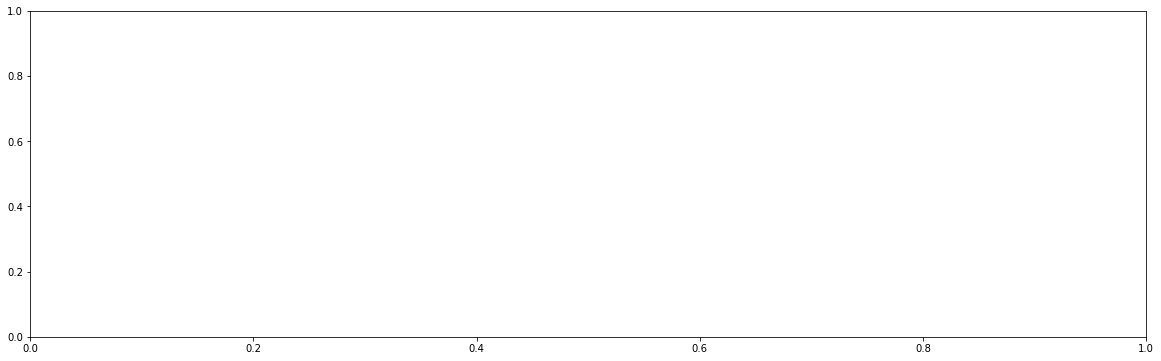

In [19]:
_, ax = plt.subplots(figsize=(20, 6))
plot_tree(dt, max_depth=2, ax=ax, feature_names=X_train.columns, impurity=False, fontsize=16);

Which shows that depending on the branch the price prediction (`value`) differs notably. The features that are selected most times to split are reflected in the `feature_importances_` field:

<table>
 <tr><td width="80"><img src="img/question.png" style="width:auto;height:auto"></td><td style="text-align:left">

Plot the importance of the 10 most important features. Which are those features? Does this make sense according to your intuition?

 </td></tr>
</table>

<table>
 <tr><td width="80"><img src="img/exclamation.png" style="width:auto;height:auto"></td><td style="text-align:left">

You may find the <a href="https://numpy.org/doc/stable/reference/generated/numpy.argsort.html?highlight=argsort#numpy.argsort">`argsort`</a> function useful when trying to obtain the most important features. Once you have them, you can use a standard bar plot with feature names as `x` axis and importances as `y` axis.

 </td></tr>
</table>

In [20]:
importancia_predictores = pd.DataFrame(
                            {' Variable predictora':X.columns,
                             'importancia': dt.feature_importances_})
selec=importancia_predictores.sort_values('importancia', ascending=False)[:10]
selec
#La variable mas importante es la edad,tiene sentido y se puede observar en la curva de depreciación vista anteriormente, el 
#resto de variables no resultan tan intuitivas.

NotFittedError: This DecisionTreeRegressor instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

In [21]:
import matplotlib.pyplot as plt
axis = selec.plot.bar(rot=0, color="purple")
print(axis)
plt.xlabel("Variables predictoras")
plt.ylabel("Importancia")
plt.title("Carácteristicas importantes")
plt.show()

NameError: name 'selec' is not defined

## Ensemble models

The model in `dt` should have convinced you that trees show predictive power for this dataset, but that it's not enough with a single tree. Time now to try tree ensembles:

<table>
 <tr><td width="80"><img src="img/question.png" style="width:auto;height:auto"></td><td style="text-align:left">

Train tree ensembles on this dataset. Feel free to edit this notebook and to try different:
* Techniques (bagging, boosting, ...).
* Implementations (sklearn, xgb, ...).
* Parameter selections (number of trees, depth of trees, ...).
     
Explain your approach. What is the best model that you can come up with?
 </td></tr>
</table>

In [22]:
####### INSERT YOUR CODE HERE
#RANDOM FOREST

# Creación del modelo
Random_forest = RandomForestRegressor(
            n_estimators = 200,
            criterion    = 'mse',
            max_depth    = 10,
            max_features = "auto",
            oob_score    = False,
            n_jobs       = -1,
         )

#Entrenar y predecir el modelo
Random_forest.fit(X_train, y_train.ravel())

predicciones_random = Random_forest.predict(X_test)


#Evaluación del modelo
rmse = mean_squared_error(
        y_true  = y_test,
        y_pred  = predicciones_random,
        squared = False
       )

print(f"El error (rmse) de test es: {rmse}")

print(Random_forest.score(X_train , y_train))
print(Random_forest.score(X_test , y_test))

ValueError: could not convert string to float: 'toyota'

<table>
 <tr><td width="80"><img src="img/question.png" style="width:auto;height:auto"></td><td style="text-align:left">

Plot the importance of the 10 most important features for the best model you find. Which are those features? Are they the same and in the same proportion than for `dt`? Why/why not?

 </td></tr>
</table>

In [23]:
####### INSERT YOUR CODE HERE
importancia_predictores = pd.DataFrame(
                            {'Variables predictoras':X.columns,
                             'importancia': Random_forest.feature_importances_})
selec=importancia_predictores.sort_values('importancia', ascending=False)[:10]
selec
#Aunque muchas de las variables de mayor importancia del modelo dt coinciden con la del random forest, algunas varian asi como
#sus proporciones.Este fenomeno es debido a que el random forest es un modelo mucho mas potente que el dt, ya que, es una 
#combinación de arboles y dt un único arbol.

NotFittedError: This RandomForestRegressor instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

In [24]:
axis = selec.plot.bar(rot=0,color="purple")
print(axis)

NameError: name 'selec' is not defined

<table>
 <tr><td width="80"><img src="img/question.png" style="width:auto;height:auto"></td><td style="text-align:left">

Compute the predictions for your best model, and plot them against the real prices in `Y_test`. Are you surprised by the results? Do the same for `Y_train` and see if the behavior has degraded considerably or not.

 </td></tr>
</table>

In [25]:
####### INSERT YOUR CODE HERE
valores_test = pd.DataFrame({"Real": np.squeeze(y_test), "Predicciones": Random_forest.predict(np.squeeze(X_test))})
valores_test

NotFittedError: This RandomForestRegressor instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

In [26]:

plt.scatter(y_test,predicciones_random,
            linewidths=1)
plt.xlabel("Real")
plt.ylabel("Prediccion")
plt.title("Precio real vs Precio predicho (test)")
plt.show()

plt.scatter(y_train,Random_forest.predict(X_train), 
           linewidths=1)
plt.xlabel("Real")
plt.ylabel("Prediccion")
plt.title("Precio real vs Precio predicho (train)")
plt.show()

#Se puede observar que los datos se comportan de manera muy similar en el conjunto de train y test. Generalmente el modelo
#predice bastante bien, aunque se pueden observar excepciones.


NameError: name 'predicciones_random' is not defined

<table>
 <tr><td width="80"><img src="img/question.png" style="width:auto;height:auto"></td><td style="text-align:left">

Find some examples of the following:
1. Cars whose price are very underestimated by the model.
2. Cars whose price are very overestimated by the model.
3. Cars whose price are almost predicted exactly by the model.
     
Can you figure out the reasons behind 1 and 2?
 </td></tr>
</table>

In [27]:
####### INSERT YOUR CODE HERE

valores_train = pd.DataFrame({"Real": np.squeeze(y_train), "Predicciones": Random_forest.predict(np.squeeze(X_train))})
valores_train

ej=pd.DataFrame(valores_train["Predicciones"]-valores_train["Real"])
ej

ej_= pd.DataFrame({"Subestimado": np.squeeze(ej[ej[0]<-20000][:3]), "Sobrestimado": np.squeeze(ej[ej[0]>20000][:3])
                  ,"Similar": np.squeeze(ej.abs().sort_values(0,ascending=True)[:3])})
ej_


#En el data frame se pueden observar 3 ejemplos de cada una de las condiciones mencionadas anteriormente, se ha establecido un umbral de 20.000 unidades 
#monetarias para seleccionar ejemplos con una subestimación y sobrestimación significativa. 
#El modelo optimiza el error medio, por lo tanto, existen muestras de entrenamiento por encima y por debajo del valor real. 

NotFittedError: This RandomForestRegressor instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

<table>
 <tr><td width="80"><img src="img/pro.png" style="width:auto;height:auto"></td><td style="text-align:left">

The above missing strategy is too restrictive. There're some columns that need to be there as we have no way of inferring `price`, `year`, `odometer`, `condition`, `title_status` and `paint_color`, but there's another column in the <a href="https://www.kaggle.com/austinreese/craigslist-carstrucks-data/download"><b>full CSV version</b></a> (`model`, the specific model of the car), from which we can infer some specific information. 
     
That is, once we know `model`, we can try to infer from the rest of the dataset its `manufacturer`, `cylinders`, `fuel`, `transmission`, `drive` and `type`. For example, if we find `model='corsa 1.4d'` we can infer that `manufacturer='opel'` and `fuel='diesel'`).
     
Can you implement this strategy? How many more rows do you obtain now?
     
Repeat the train/test split and the model training with this extended dataset. Can you improve on previous results? By how much?  

 </td></tr>
</table>

<table>
 <tr><td width="80"><img src="img/pro.png" style="width:auto;height:auto"></td><td style="text-align:left">

Besides `model`, there are yet more features in that full CSV file that can be loaded:
* `url`: URL with the original second-hand car ad.
* `image_url`: URL with a photo of the car.
* `region`: region in the United States where the car was being sold.
* `region_url`: URL with Craigslist link of that region.
* `vin`: Vehicle Identification Number of the car.
* `description`: the text on the car ad itself (kind of free text).
* `county`: US county where the car was being sold.
* `state`: US state where the car was being sold.
* `lat`: exact latitude of the car.
* `lon`: exact longitude of the car.
     
Which of these would you use to build better models? Try to use any of these and see if you can further improve (more points the more you try and the more you improve!).
 </td></tr>
</table>